In [ ]:
import pandas as pd
import numpy as np
import re
from flashtext import KeywordProcessor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
from datetime import timedelta, datetime
import joblib

company_data = pd.read_csv("company_data_rework.csv")
news_benzinga = pd.read_csv("raw_analyst_ratings.csv")

common_suffixes = ["inc", "inc.", "corp", "corp.", "ltd", "ltd.", "plc", "co", "co.", "s.a.", "s.p.a.", "ag"]
def clean_company_name(name: str) -> str:
    name = re.sub(r'[^a-zA-Z0-9 ]', '', name)
    for suffix in common_suffixes:
        name = re.sub(rf'\b{suffix}\b', '', name, flags=re.IGNORECASE).strip()
    return name

company_data["clean_name"] = company_data["Name"].apply(clean_company_name)
company_lookup = dict(zip(company_data["Ticker"], company_data["clean_name"]))

# FlashText for matching
keyword_processor = KeywordProcessor()
for ticker, name in company_lookup.items():
    keyword_processor.add_keyword(name, ticker)
    keyword_processor.add_keyword(ticker, ticker)

def find_mentioned_companies(title):
    if pd.isna(title):
        return []
    return list(set(keyword_processor.extract_keywords(title.lower())))

news_benzinga["mentioned_companies"] = news_benzinga["headline"].apply(find_mentioned_companies)
news_benzinga = news_benzinga[news_benzinga["mentioned_companies"].apply(lambda x: len(x) > 0)]
news_benzinga["date_processed"] = pd.to_datetime(news_benzinga["date"], utc=True, errors='coerce').dt.date

# Sentiment scoring
analyzer = SentimentIntensityAnalyzer()
def extract_company_sentiment(title, mentioned_companies):
    results = []
    for company in mentioned_companies:
        if pd.isna(title):
            results.append(0)
            continue
        pattern = rf'\b{re.escape(company)}\b'
        match = re.search(pattern, title, re.IGNORECASE)
        if match:
            context = title[max(0, match.start() - 20): match.end() + 20]
        else:
            context = title
        sentiment = analyzer.polarity_scores(context)
        results.append(sentiment["pos"] - sentiment["neg"])
    return results

news_benzinga["sentiment_scores"] = news_benzinga.apply(
    lambda row: extract_company_sentiment(row["headline"], row["mentioned_companies"]), axis=1
)

# Build ticker -> date -> sentiment dictionary
def build_ticker_score_dict(df):
    ticker_scores = {}
    for _, row in df.iterrows():
        date = str(row["date_processed"])
        tickers = row["mentioned_companies"]
        scores = row["sentiment_scores"]
        for ticker, score in zip(tickers, scores):
            if ticker not in ticker_scores:
                ticker_scores[ticker] = {}
            if date not in ticker_scores[ticker]:
                ticker_scores[ticker][date] = []
            ticker_scores[ticker][date].append(score)
    return ticker_scores

sentiment_by_ticker = build_ticker_score_dict(news_benzinga)


In [3]:
from datetime import datetime

# Example: Ticker list from sentiment data
tickers = list(sentiment_by_ticker.keys())

# Define date range based on your sentiment data
all_sentiment_dates = []
for ticker_data in sentiment_by_ticker.values():
    all_sentiment_dates.extend(pd.to_datetime(list(ticker_data.keys()), errors='coerce'))

start_date = str(min(all_sentiment_dates).date())
end_date = str(max(all_sentiment_dates).date())

print(f"Downloading stock data from {start_date} to {end_date} for {len(tickers)} tickers...")

# Download function (your modified version)
def download_price_and_volatility(ticker_list, start_date, end_date, volatility_window=5):
    price_data = {}
    for ticker in ticker_list:
        try:
            df = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                interval='1d',
                group_by='ticker',
                auto_adjust=True,
                multi_level_index=False
            )
            if not df.empty:
                df['Return'] = np.log(df['Close']).diff()
                df['Volatility'] = df['Return'].rolling(window=volatility_window).std()
                price_data[ticker] = df
        except Exception as e:
            print(f"Failed for {ticker}: {e}")
    return price_data

# Run the download
stock_price_data = download_price_and_volatility(
    ticker_list=tickers,
    start_date=start_date,
    end_date=end_date,
    volatility_window=5
)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['L']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['C']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['D']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KEY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EA']: YFRateLimitError('Too Many Requests. Rate limited. Try afte

In [ ]:
# Load the price data
stock_price_data = joblib.load("exptest2_27_04_stock_price_data.pkl")

# Process each ticker's DataFrame individually
for ticker, df in stock_price_data.items():
    if not isinstance(df, pd.DataFrame) or 'Close' not in df.columns:
        continue  # skip invalid entries

    df = df.sort_index()  # Ensure chronological order
    df['Return'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
    df['Volatility'] = df['Return'].rolling(window=20).std()

    # Save back to dict
    stock_price_data[ticker] = df

In [14]:
def backtest_sentiment_portfolio(sentiment_dict, price_data,
                                 initial_capital=100000,
                                 sentiment_threshold=0.2,
                                 volatility_window=5):
    """
    Backtest a sentiment-based strategy with volatility-adjusted sizing.

    Parameters:
    - sentiment_dict: ticker -> date -> list of sentiment scores
    - price_data: dict of {ticker: price DataFrame with 'Return' and 'Volatility'}
    - initial_capital: float
    - sentiment_threshold: float
    - volatility_window: int (already used to compute volatility before)

    Returns:
    - DataFrame of daily returns
    - Final portfolio value
    - Sharpe ratio (annualized)
    """
    tickers = list(price_data.keys())
    
    # Extract valid start and end dates from sentiment_dict and price_data
    valid_start_dates = []
    for v in sentiment_dict.values():
        for k in v.keys():
            dt = pd.to_datetime(k, errors='coerce')
            if pd.notna(dt):
                valid_start_dates.append(dt)

    if not valid_start_dates:
        raise ValueError("No valid dates found in sentiment_dict.")

    start_date = min(valid_start_dates).date()
    end_date = max(max(df.index).date() for df in price_data.values() if not df.empty)

    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")


    portfolio_value = initial_capital
    daily_returns = []

    for current_date in all_dates:
        date_str = str(current_date.date())
        signals = {}

        for ticker in tickers:
            if ticker not in sentiment_dict or ticker not in price_data:
                continue
            if date_str in sentiment_dict[ticker]:
                avg_sent = np.mean(sentiment_dict[ticker][date_str])
                if abs(avg_sent) >= sentiment_threshold:
                    signals[ticker] = np.sign(avg_sent)

        if not signals:
            daily_returns.append(0)
            continue

        inv_vols = {}
        for ticker in signals:
            try:
                vol = price_data[ticker].loc[current_date, 'Volatility']
                if not pd.isna(vol) and vol > 0:
                    inv_vols[ticker] = 1 / vol
            except:
                continue

        if not inv_vols:
            daily_returns.append(0)
            continue

        total_inv_vol = sum(inv_vols.values())
        weights = {t: inv_vols[t] / total_inv_vol for t in inv_vols}

        portfolio_return = 0
        for ticker, direction in signals.items():
            try:
                r = price_data[ticker].loc[current_date + pd.Timedelta(days=1), 'Return']
                if not pd.isna(r):
                    portfolio_return += weights.get(ticker, 0) * direction * r
            except:
                continue

        daily_returns.append(portfolio_return)
        portfolio_value *= (1 + portfolio_return)

    daily_returns = np.array(daily_returns)
    sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252) if np.std(daily_returns) > 0 else 0
    returns_df = pd.DataFrame({'Date': all_dates, 'Daily Return': daily_returns}).set_index('Date')
    return returns_df, portfolio_value, sharpe_ratio


🔹 Final Portfolio Value: $166,113.01
🔹 Annualized Sharpe Ratio: 0.37
🔹 Total Return: 66.11%
🔹 Avg Daily Return: 0.0001
🔹 Std Dev Daily Return: 0.0063
🔹 Max Drawdown: 26.85%


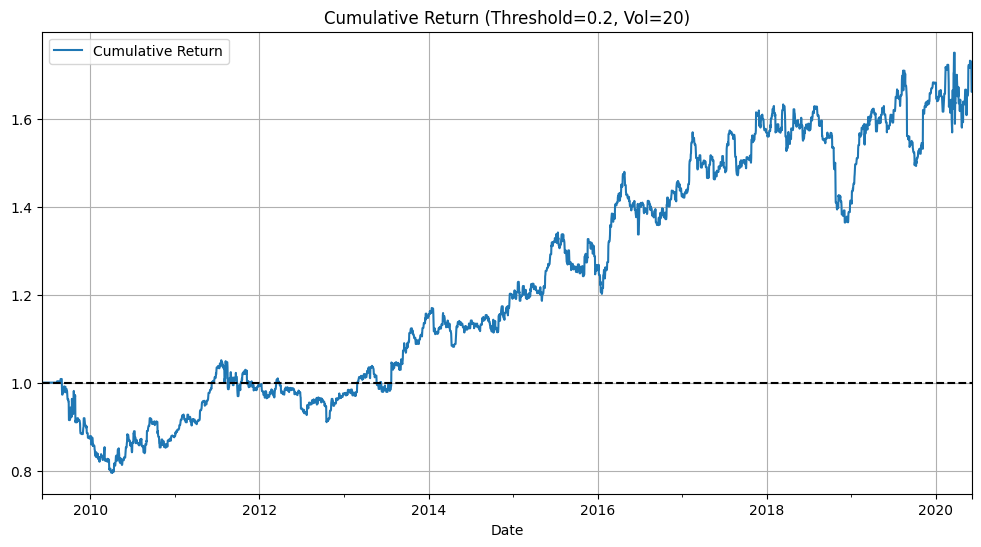

In [15]:
returns_df, final_val, sharpe = run_full_backtest(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    sentiment_threshold=0.2,
    volatility_window=20
)


🔹 Final Portfolio Value: $166,113.01
🔹 Annualized Sharpe Ratio: 0.37
🔹 Total Return: 66.11%
🔹 Avg Daily Return: 0.0001
🔹 Std Dev Daily Return: 0.0063
🔹 Max Drawdown: 26.85%


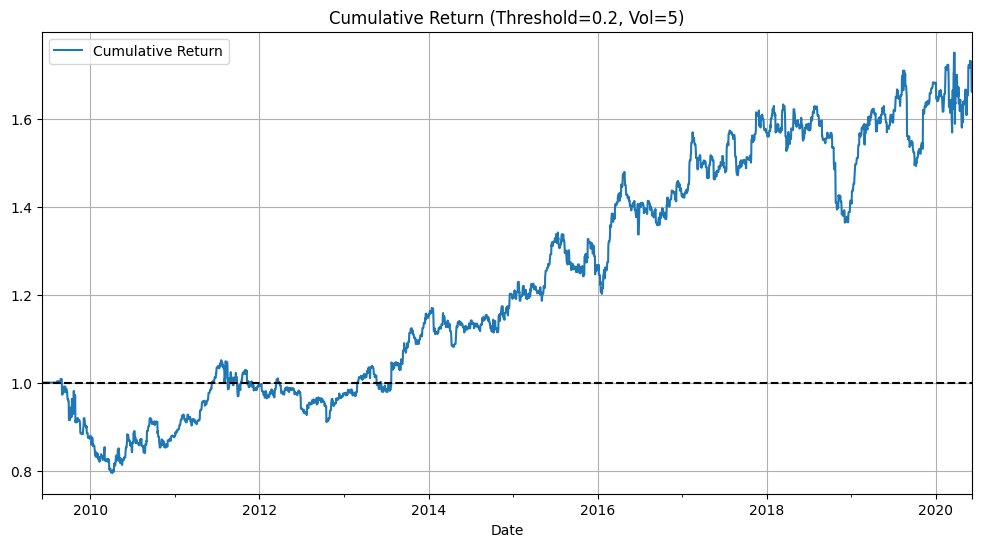

In [19]:
returns_df, final_val, sharpe = run_full_backtest(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    sentiment_threshold=0.2,
    volatility_window=5)
